In [1]:
from tqdm.notebook import tqdm
from nltk import sent_tokenize
from transformers import AutoTokenizer
import sys
import seaborn as sb
sys.path.append('../..')

from src import *
from src.test_utils import *

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [2]:
# gritlm = GritLM("GritLM/GritLM-7B", device_map="cuda:2", torch_dtype="auto")
retriever = Retriever(device='cuda:0', syn_dist=0.1)
# llm = LLM()
# llm = 'mistralai/Mistral-7B-Instruct-v0.2'
llm = None
longdoc = LongDoc(retriever, llm)
# dataset = NarrativeQADataset(llm)
dataset = QualityDataset(llm, split='dev')
# reading_agent = ReadingAgent(dataset, llm)

In [3]:
test_i = 2
results = [ChunkInfo(**ci) for ci in read_json(os.path.join(dataset.data_dir, f'index_wg_1_1_{test_i}.json'))]
relation_graph = longdoc.build_relation_graph(results)
pages = [ci.passage for ci in results]
questions, answers = dataset.get_questions_and_answers(dataset.data[test_i])
questions = [q.splitlines()[0] for q in questions]
questions

['What is the most likely meaning of the slang O.Q.? (in twentieth-century American English)',
 'Why does the Skipper stop abruptly after he says "when you\'re running a blockade"?',
 'Who or what is Leo?',
 'Why does the Skipper allow the new chef to use the heat-cannon as an incinerator?',
 ' Lieutenant Dugan brings up the examples of "High G" Gordon and "Runt" Hake in order to illustrates that...',
 "Why didn't the Skipper follow the new cook's advice about avoiding Vesta?",
 'Why was the new cook so upset that the Skipper decided to surrender?',
 'What does the Skipper mean by "lady-logic"?',
 "What would've happened if the new cook had told the Skipper about the ekalastron deposits earlier?"]

In [4]:
for ci in results:
    # print(len(gritlm.tokenizer(ci.passage)['input_ids']))
    print(len(retriever.retriever_tokenizer(ci.passage)['input_ids']))

252
194
247
252
221
250
242
225
256
227
235
254
244
244
217
226
256
205
238
244
254
237
219
245
251
237
255
255
253
250
203


# Index passages

In [ ]:
paragraphs = read_json(os.path.join(dataset.data_dir, f'pages_{2}.json'))

## Eval

In [ ]:
results[11].print()

In [ ]:
results[11].prev_summaries

In [ ]:
print(results[11].recap_str)

# Retrieval

In [4]:
qid = 5
question = questions[qid]
print(question)

Why didn't the Skipper follow the new cook's advice about avoiding Vesta?


## Eval

### Contriever

#### Query Encode With Note, Doc Encode Without Note

In [ ]:
ent_candidates = longdoc.collect_entities_from_text(questions[qid])
prev_ent_descriptions, prev_relation_descriptions = longdoc.retrieve_descriptions(results, relation_graph, ent_candidates, 1, 2)
q_info = ChunkInfo(len(results), questions[qid], prev_ent_descriptions=prev_ent_descriptions, prev_relation_descriptions=prev_relation_descriptions)
recap_str = f'''Recap:\n{q_info.recap_str}\n\nQuery:\n'''
full_input = recap_str + questions[qid]
print(len(retriever.retriever_tokenizer(full_input)['input_ids']))

q_embedding = retriever.embed_paragraphs([full_input], normalize=False, complete_return=True)
page_embeddings = retriever.embed_paragraphs(pages, normalize=False, complete_return=True)
c_retriever_tokenizer = retriever.retriever_tokenizer
c_q_input_ids, c_q_emb, c_q_lhs = hidden_states_wo_instruction(q_embedding.input_ids.copy(), q_embedding.last_hidden_states.copy(), q_embedding.attention_mask.copy(), c_retriever_tokenizer([recap_str])['attention_mask'], True)
c_p_input_ids, c_p_emb, c_p_lhs = hidden_states_wo_instruction(page_embeddings.input_ids.copy(), page_embeddings.last_hidden_states.copy(), page_embeddings.attention_mask.copy(), c_retriever_tokenizer([''])['attention_mask'], True)
c_pids, c_scores = retriever.dense_retrieval(c_q_emb, c_p_emb, None, normalize=False, return_score=True)
q_spans = word_split(c_q_input_ids[0], c_retriever_tokenizer, False, True)
query_indicatiors(c_retriever_tokenizer, questions[qid], pages, c_q_lhs[0], c_q_input_ids[0], c_p_lhs, c_p_input_ids, c_pids, c_scores, q_spans=q_spans)

#### Query Encode Without Note, Doc Encode Without Note

In [ ]:
recap_str = ''
full_input = recap_str + questions[qid]
print(len(retriever.retriever_tokenizer(full_input)['input_ids']))

q_embedding = retriever.embed_paragraphs([full_input], normalize=False, complete_return=True)
page_embeddings = retriever.embed_paragraphs(pages, normalize=False, complete_return=True)
c_retriever_tokenizer = retriever.retriever_tokenizer
c_q_input_ids, c_q_emb, c_q_lhs = hidden_states_wo_instruction(q_embedding.input_ids.copy(), q_embedding.last_hidden_states.copy(), q_embedding.attention_mask.copy(), c_retriever_tokenizer([recap_str])['attention_mask'], True)
c_p_input_ids, c_p_emb, c_p_lhs = hidden_states_wo_instruction(page_embeddings.input_ids.copy(), page_embeddings.last_hidden_states.copy(), page_embeddings.attention_mask.copy(), c_retriever_tokenizer([''])['attention_mask'], True)
c_pids, c_scores = retriever.dense_retrieval(c_q_emb, c_p_emb, None, normalize=False, return_score=True)
q_spans = word_split(c_q_input_ids[0], c_retriever_tokenizer, False, True)
query_indicatiors(c_retriever_tokenizer, questions[qid], pages, c_q_lhs[0], c_q_input_ids[0], c_p_lhs, c_p_input_ids, c_pids, c_scores)#, q_spans=q_spans)

### GritLM

#### Query Encode With Note, Doc Encode With Note

In [ ]:
ent_candidates = longdoc.collect_entities_from_text(questions[qid])
prev_ent_descriptions, prev_relation_descriptions = longdoc.retrieve_descriptions(results, relation_graph, ent_candidates, 4, True)
q_info = ChunkInfo(len(results), questions[qid], prev_ent_descriptions=prev_ent_descriptions, prev_relation_descriptions=prev_relation_descriptions)
g_q_emb, g_q_input_ids, g_q_lhs = gritlm.encode([questions[qid]], max_length=8192, instructions=[LongDocPrompt.embed_w_note(q_info.recap_str, 'query')])

g_p_emb, g_p_input_ids, g_p_lhs = gritlm.encode(pages, batch_size=5, max_length=8192, instructions=[LongDocPrompt.embed_w_note(ci.recap_str, 'passage') for ci in results])
g_retriever_tokenizer = gritlm.tokenizer
q_spans = word_split(g_q_input_ids[0], g_retriever_tokenizer)
g_pids, g_scores = retriever.dense_retrieval(g_q_emb, g_p_emb, None, normalize=False, return_score=True)
query_indicatiors(g_retriever_tokenizer, questions[qid], pages, g_q_lhs[0], g_q_input_ids[0], g_p_lhs, g_p_input_ids, g_pids, g_scores)#, q_spans=q_spans)

#### Query Encode Without Note, Doc Encode With Note

In [ ]:
g_q_emb, g_q_input_ids, g_q_lhs = gritlm.encode([questions[qid]])#, instructions=["Retrieve relevant passages from a story to answer a given question."])

g_p_emb, g_p_input_ids, g_p_lhs = gritlm.encode(pages, batch_size=5, max_length=8192, instructions=[LongDocPrompt.embed_w_note(ci.recap_str, 'passage') for ci in results])
g_retriever_tokenizer = gritlm.tokenizer
q_spans = word_split(g_q_input_ids[0], g_retriever_tokenizer)
g_pids, g_scores = retriever.dense_retrieval(g_q_emb, g_p_emb, None, normalize=False, return_score=True)
query_indicatiors(g_retriever_tokenizer, questions[qid], pages, g_q_lhs[0], g_q_input_ids[0], g_p_lhs, g_p_input_ids, g_pids, g_scores)#, q_spans=q_spans)

#### Query Encode With Note, Doc Encode Without Note

In [ ]:
ent_candidates = longdoc.collect_entities_from_text(questions[qid])
prev_ent_descriptions, prev_relation_descriptions = longdoc.retrieve_descriptions(results, relation_graph, ent_candidates, 1, 2)

In [ ]:
prev_ent_descriptions

In [ ]:
prev_relation_descriptions

In [ ]:
ent_candidates = longdoc.collect_entities_from_text(questions[qid])
prev_ent_descriptions, prev_relation_descriptions = longdoc.retrieve_descriptions(results, relation_graph, ent_candidates, 1, 2)
q_info = ChunkInfo(len(results), questions[qid], prev_ent_descriptions=prev_ent_descriptions, prev_relation_descriptions=prev_relation_descriptions)
instruction = gritlm.gritlm_instruction('Use the recap context to help you understand the query and retrieve relevant passages from a story to answer the query.')
recap_str = f'''{instruction}\nRecap:\n{q_info.recap_str}\n\nQuery:\n'''
print(len(gritlm.tokenizer(recap_str + questions[qid])['input_ids']))
g_q_emb, g_q_input_ids, g_q_lhs = gritlm.encode([questions[qid]], max_length=8192, instructions=[recap_str])

g_p_emb, g_p_input_ids, g_p_lhs = gritlm.encode(pages, max_length=8192)
g_retriever_tokenizer = gritlm.tokenizer
q_spans = word_split(g_q_input_ids[0], g_retriever_tokenizer)
g_pids, g_scores = retriever.dense_retrieval(g_q_emb, g_p_emb, None, normalize=False, return_score=True)
query_indicatiors(g_retriever_tokenizer, questions[qid], pages, g_q_lhs[0], g_q_input_ids[0], g_p_lhs, g_p_input_ids, g_pids, g_scores, q_spans=q_spans)

In [ ]:
important_page_tokens(g_retriever_tokenizer, questions[qid], pages, g_q_lhs[0], g_q_input_ids[0], g_q_emb[0], g_p_lhs, g_p_input_ids, g_pids, g_scores)

#### Query Encode Without Note, Doc Encode Without Note

In [ ]:
g_q_emb, g_q_input_ids, g_q_lhs = gritlm.encode([questions[qid]], instructions=[gritlm.gritlm_instruction("Retrieve relevant passages from a story to answer a given question.")])

g_p_emb, g_p_input_ids, g_p_lhs = gritlm.encode(pages, max_length=8192)
g_retriever_tokenizer = gritlm.tokenizer
q_spans = word_split(g_q_input_ids[0], g_retriever_tokenizer)
g_pids, g_scores = retriever.dense_retrieval(g_q_emb, g_p_emb, None, normalize=False, return_score=True)
query_indicatiors(g_retriever_tokenizer, questions[qid], pages, g_q_lhs[0], g_q_input_ids[0], g_p_lhs, g_p_input_ids, g_pids, g_scores, q_spans=q_spans)

## Test Code

In [ ]:
prev_ent_descriptions, prev_relation_descriptions = longdoc.retrieve_descriptions(results, relation_graph, ent_candidates, 1, 2)

In [ ]:
# Encode questions
q_emb = retriever.embed_paragraphs([f"query: {q}" for q in ["The Skipper", "The Skipper didn't", "'I won't listen to your advice.' said the Old Man.", "The Skipper didn't follow the advice.", "The Skipper didn't follow the advice. The Skipper is also called 'Old Man' in the passage.", "The Skipper is also called 'Old Man' in the passage. The Skipper didn't follow the advice."]], normalize=True, complete_return=True)
q_strs, q_lhs = [], []
for qid in range(len(q_emb.embeddings)):
    word_spans = word_split(q_emb.input_ids[qid], retriever.retriever_tokenizer, retriever.retriever_tokenizer.bos_token, retriever.retriever_tokenizer.eos_token)
    temp_q_strs, temp_q_lhs = merge_words_and_embeddings(retriever.retriever_tokenizer, q_emb.input_ids[qid], q_emb.last_hidden_states[qid], word_spans, False)
    q_strs.append(temp_q_strs)
    q_lhs.append(temp_q_lhs)

In [5]:
# Encode pages
p_emb = retriever.embed_paragraphs([f"passage: {p}" for p in pages], normalize=True, complete_return=True)
p_strs, p_lhs = [], []
for pid in range(len(p_emb.embeddings)):
    word_spans = sent_split(p_emb.input_ids[pid], retriever.retriever_tokenizer, retriever.retriever_tokenizer.bos_token, retriever.retriever_tokenizer.eos_token)
    # word_spans = word_split(p_emb.input_ids[pid], retriever.retriever_tokenizer, retriever.retriever_tokenizer.bos_token, retriever.retriever_tokenizer.eos_token)
    temp_p_strs, temp_p_lhs = merge_words_and_embeddings(retriever.retriever_tokenizer, p_emb.input_ids[pid], p_emb.last_hidden_states[pid], word_spans, False)
    p_strs.append(temp_p_strs)
    p_lhs.append(temp_p_lhs)
tsne_plot(p_emb.embeddings)

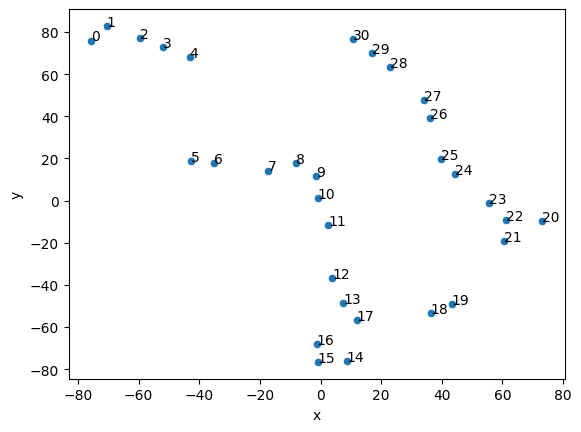

In [6]:
# Encode pages with note
notes = [f'Recap: {"" if cid == 0 else results[cid-1].summary}\n' for cid in range(len(results))]
noted_passages = [note + f'Passage: {ci.passage}' for note, ci in zip(notes, results)]
p_emb = retriever.embed_paragraphs(noted_passages, normalize=False, complete_return=True)
# (p_input_ids, p_embeddings, p_last_hidden_states), bos_token = hidden_states_wo_instruction(
#     p_emb.input_ids.copy(), 
#     p_emb.last_hidden_states.copy(), 
#     p_emb.attention_mask.copy(), 
#     retriever.retriever_tokenizer.batch_encode_plus(notes, padding=True, truncation=True, return_tensors='pt')['attention_mask'], 
#     True), ''
p_input_ids, p_embeddings, p_last_hidden_states, bos_token = p_emb.input_ids, p_emb.embeddings, p_emb.last_hidden_states, retriever.retriever_tokenizer.bos_token
p_strs, p_lhs = [], []
for pid in range(len(p_emb.embeddings)):
    word_spans = sent_split(p_input_ids[pid], retriever.retriever_tokenizer, bos_token, retriever.retriever_tokenizer.eos_token)
    # word_spans = word_split(p_emb.input_ids[pid], retriever.retriever_tokenizer, retriever.retriever_tokenizer.bos_token, retriever.retriever_tokenizer.eos_token)
    temp_p_strs, temp_p_lhs = merge_words_and_embeddings(retriever.retriever_tokenizer, p_input_ids[pid], p_last_hidden_states[pid], word_spans, False, False)
    p_strs.append(temp_p_strs)
    p_lhs.append(temp_p_lhs)
tsne_plot(p_embeddings)

In [7]:
def print_input_ids(p_strs:List[List[str]], iids:List[int]):
    for iid in iids:
        print(iid, ' '.join(p_strs[iid]))

In [11]:
print_input_ids(p_strs, [20, 21, 22, 23])

20 Recap: On the first day of their journey from Mars, the galley experienced an unexpected departure of a bashful and humorless cook. The Leo, traveling at 400,000 m.p.h., was expected to take at least ten days to reach the disputed region near Vesta. Passage: That period of jetting was a mingled joy and pain in the britches. Captain Slops was responsible for both. For one thing, as I've hinted before, he was a bit of a panty-waist. It wasn't so much the squeaky voice or the effeminate gestures he cut loose with from time to time. One of the roughest, toughest scoundrels who ever cut a throat on Venus was "High G" Gordon, who talked like a boy soprano, and the meanest pirate who ever highjacked a freighter was "Runt" Hake—who wore diamond ear-rings and gold fingernail polish! But it was Slops' general attitude that isolated him from the command and crew. In addition to being a most awful prude, he was a kill-joy. When just for a lark we begged him to boil us a pot of spaghetti, so we 

In [13]:
print_input_ids(p_strs, [10, 11, 12, 13])

10 Recap: The young cook, Andy Laney, suggests running the blockade near Iris but is scolded by the Old Man for giving advice. He apologizes to Mr. Dugan and is ordered back to the galley. The Old Man sternly tells Andy to focus on his cooking duties and not give orders. Andy leaves, frustrated. Passage: So we hit the spaceways for Vesta, and after a while the Old Man called up the crew and told them our destination, and if you think they were scared or nervous or anything like that, why, you just don't know spacemen. From oil-soaked old Jock McMurtrie, the Chief Engineer, all the way down the line to Willy, our cabin-boy, the Leo's complement was as thrilled as a sub-deb at an Academy hop. John Wainwright, our First Officer, licked his chops like a fox in a hen-house and said, "The blockade! Oboyoboy! Maybe we'll tangle with one of the Alliance ships, hey?" Blinky Todd, an ordinary with highest rating, said with a sort of macabre satisfaction, "I hopes we do meet up with 'em, that's w

In [12]:
pages[7:9]

['And if this young man can cook—" The skipper\'s color subsided. So did he, grumbling. "Well, perhaps you\'re right, Dugan. All right, Slops, you\'re hired. The galley\'s on the second level, port side. Mess in three quarters of an hour. Get going! Dugan, call McMurtrie and tell him we lift gravs immediately— Slops! What are you doing at that table?" For the little fellow had sidled across the control-room and now, eyes gleaming inquisitively, was peering at our trajectory charts. At the skipper\'s roar he glanced up at us eagerly. "Vesta!" he piped in that curiously high-pitched and mellow voice. "Loft trajectory for Vesta! Then we\'re trying to run the Alliance blockade, Captain?" "None of your business!" bellowed O\'Hara in tones of thunderous outrage.',
 '"Get below instantly, or by the lavendar lakes of Luna I\'ll—" "If I were you," interrupted our diminutive new chef thoughtfully, "I\'d try to broach the blockade off Iris rather than Vesta. For one thing, their patrol line will 

In [ ]:
# Question-question token-token matching
xid, yid = 4, 2
x_start, x_end = 0, None
y_start, y_end = 0, None

score_mat = (q_lhs[yid] / np.expand_dims(np.linalg.norm(q_lhs[yid], axis=1), axis=1)) @ (q_lhs[xid] / np.expand_dims(np.linalg.norm(q_lhs[xid], axis=1), axis=1)).T
score_mat = score_mat[y_start:y_end, x_start:x_end]
fig, ax = plt.subplots(figsize=(score_mat.shape[1], score_mat.shape[0]))
sb.heatmap(score_mat, xticklabels=q_strs[xid][x_start:x_end], yticklabels=q_strs[yid][y_start:y_end], annot=True, ax=ax)
fig.savefig('qq.pdf')

In [ ]:
sents = []
for ci in results:
    for k in ci.ent_descriptions:
        if 'old man' in k.lower():
            sents.append(f'{k}: {ci.ent_descriptions[k]}')

In [ ]:
# Question-page token-sent matching
xid, yid = 1, 0
x_start, x_end = 0, None
y_start, y_end = 0, None

score_mat = (q_lhs[yid] / np.expand_dims(np.linalg.norm(q_lhs[yid], axis=1), axis=1)) @ (p_lhs[xid] / np.expand_dims(np.linalg.norm(p_lhs[xid], axis=1), axis=1)).T
score_mat = score_mat[y_start:y_end, x_start:x_end]
fig, ax = plt.subplots(figsize=(score_mat.shape[1], score_mat.shape[0]))
sb.heatmap(score_mat, xticklabels=p_strs[xid][x_start:x_end], yticklabels=q_strs[yid][y_start:y_end], annot=True, ax=ax)
fig.savefig('qp.pdf')

In [ ]:
# Page-page matching
score_mat = p_emb.embeddings @ p_emb.embeddings.T
fig, ax = plt.subplots(figsize=(score_mat.shape[1], score_mat.shape[0]))
sb.heatmap(score_mat, xticklabels=range(score_mat.shape[1]), yticklabels=range(score_mat.shape[0]), annot=True, ax=ax)
fig.savefig('pp_all.pdf')

In [ ]:
# Page-page sent-sent matching
xid, yid = 9, 10
x_start, x_end = 0, None
y_start, y_end = 0, None

score_mat = (p_lhs[yid] / np.expand_dims(np.linalg.norm(p_lhs[yid], axis=1), axis=1)) @ (p_lhs[xid] / np.expand_dims(np.linalg.norm(p_lhs[xid], axis=1), axis=1)).T
score_mat = score_mat[y_start:y_end, x_start:x_end]
fig, ax = plt.subplots(figsize=(score_mat.shape[1]/2, score_mat.shape[0]/2))
sb.heatmap(score_mat, xticklabels=range(x_start, score_mat.shape[1] + x_start), yticklabels=range(y_start, score_mat.shape[0] + y_start), annot=True, ax=ax)
fig.savefig('pp.pdf')
print('x:\n', pages[xid])
print('y:\n', pages[yid])

In [ ]:
test_x_sent = 2
test_y_sent = 2
print(score_mat[test_y_sent, test_x_sent])
print(p_strs[xid][test_x_sent])
print(p_strs[yid][test_y_sent])

In [32]:
doc_split = DocSplit('intfloat/multilingual-e5-large')
window_size = 1
pages = doc_split.split_paragraphs(dataset.get_article(dataset.data[2]), 512 // 2)
pages = [p for p in pages if p]
padded_pages = ([''] * (window_size-1)) + pages + ([''] * (window_size-1))
p_input_ids = [doc_split.llm_tokenizer(p)['input_ids'][1:-1] for p in pages]
batched_pids = [[pid_ - window_size + 1 for pid_ in range(pid, pid + window_size) if padded_pages[pid_]] for pid in range(len(padded_pages) - window_size + 1)]
reformed_pages = [' '.join([pages[pid] for pid in pids]) for pids in batched_pids]
p_emb = retriever.embed_paragraphs(reformed_pages, complete_return=True)
pid2embs = [[] for p in pages]
for temp_input_ids, temp_lhs, pids in zip(p_emb.input_ids, p_emb.last_hidden_states, batched_pids):
    spans = []
    p_start = 1
    for pid in pids:
        p_len = len(p_input_ids[pid])
        p_end = p_start + p_len
        if temp_input_ids[p_start:p_end].tolist() != p_input_ids[pid]: # align check
            print('fail')
            break
        pid2embs[pid].append(temp_lhs[p_start:p_end].mean(0))
        p_start = p_end
pid2embs = [np.vstack(embs) for embs in pid2embs]

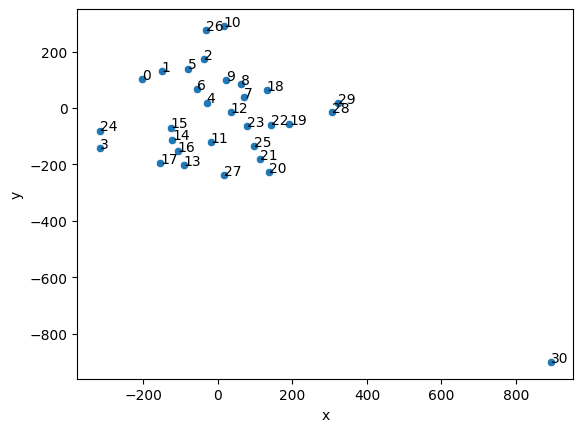

In [33]:
p_weight = np.array([[1.]])
p_embeddings = np.vstack([(p_weight @ embs)[0] for embs in pid2embs])
tsne_plot(p_embeddings)

In [22]:
p_embeddings[0].shape

(1024,)

In [9]:
len(pages)

85

In [13]:
a = np.array(range(20)).reshape((4,5))

In [20]:
np.expand_dims(a, -1).shape

(4, 5, 1)

In [15]:
a.mean(1)

array([ 2.,  7., 12., 17.])

In [ ]:
len(pid2embs[33])

In [ ]:
p_lhs = [np.array(pid2embs[pid]).mean(0) for pid in range(len(pid2embs))]
p_embeddings = np.array([lhs.mean(0) for lhs in p_lhs])
p_norm = np.linalg.norm(p_embeddings, axis=1)
p_embeddings = p_embeddings / np.expand_dims(p_norm, 1)
p_lhs = [lhs / n for lhs, n in zip(p_lhs, p_norm)]
pids, scores = retriever.dense_retrieval(q_emb.embeddings, p_embeddings, None, normalize=False, return_score=True)
pids

In [ ]:
query_distribution(retriever.retriever_tokenizer, q_emb.last_hidden_states[0], q_emb.input_ids[0], p_lhs, 5, q_spans=word_spans[3:-1])

In [ ]:
pages[13]

In [ ]:
query_indicatiors(retriever.retriever_tokenizer, question, [f'passage: {p}' for p in pages], q_emb.last_hidden_states[0], q_emb.input_ids[0], p_lhs, p_input_ids, pids[:10], scores, 5, q_spans=word_spans)

In [ ]:
p_emb = retriever.embed_paragraphs([f'passage: {p}' for p in pages], normalize=True, complete_return=True)
pids, scores = retriever.dense_retrieval(q_emb.embeddings, p_emb.embeddings, None, normalize=False, return_score=True)
pids

In [ ]:
query_indicatiors(retriever.retriever_tokenizer, question, [f'passage: {p}' for p in pages], q_emb.last_hidden_states[0], q_emb.input_ids[0], p_emb.last_hidden_states, p_emb.input_ids, pids, scores, q_spans=word_spans)

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Cursor

# Fixing random state for reproducibility
np.random.seed(19680801)

fig, ax = plt.subplots(figsize=(8, 6))

x, y = 4*(np.random.rand(2, 100) - .5)
ax.plot(x, y, 'o')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# Set useblit=True on most backends for enhanced performance.
cursor = Cursor(ax, useblit=True, color='red', linewidth=2)

plt.show()